##  Fake News Detection using NLP

### Dataset Description

1. True.csv – Contains authentic news articles.
2. Fake.csv – Contains fake news articles.

### 1. Dataset Loading

In [1]:
# Import required Libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_true = pd.read_csv(r"E:\IRL\Machine Learning\Assignments\True.csv")
df_fake = pd.read_csv(r"E:\IRL\Machine Learning\Assignments\Fake.csv")

In [3]:
# Add new column labels
df_true['label'] = 1
df_fake['label'] = 0

### Combine Data

In [4]:
data = pd.concat([df_true, df_fake], axis=0).sample(frac=1).reset_index(drop=True)
data.head()

,title,text,subject,date,label
0,"Trump Blames Charlotte Rioting On Drug Use, W...","Another day, another racist dog whistle echoed...",News,"September 22, 2016",0
1,No man an island - China warns against strayin...,BEIJING (Reuters) - Members of China s ruling ...,worldnews,"December 22, 2017",1
2,CNN Panel On Melania’s Cyberbullying Stance: ...,The wife of a cyberbully spoke today about wha...,News,"November 3, 2016",0
3,Trump says immigration deal with Democrats clo...,WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"September 14, 2017",1
4,Episode 3 – DRIVE BY WIRE: ‘Under New Manageme...,MEMBERS can join co-hosts Patrick Henningsen ...,Middle-east,"January 29, 2017",0


### 2. Data Understanding

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [6]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [7]:
data.duplicated().sum()

np.int64(209)

In [8]:
# Drop duplicates.
data = data.drop_duplicates()

In [9]:
data['label'].value_counts()

label
0    23478
1    21211
Name: count, dtype: int64

#### 3. Data Cleaning and Preprocessing

In [10]:
# Importing necessary Libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer 
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [11]:
#  Download required NLTK data
for pkg in ['stopwords', 'punkt', 'wordnet', 'omw-1.4']:
    nltk.download(pkg, quiet=True)

#  Initialize resources
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

#  Define preprocessing function
def preprocess(raw_text, flag='lemma'):

    # Step 1: Clean text (remove non-alphabets, lowercasing)
    sentence = re.sub("[^a-zA-Z.]", " ", str(raw_text))
    sentence = sentence.lower()
    
    # Step 2: Tokenize
    tokens = sentence.split()
    
    # Step 3: Remove stopwords
    clean_tokens = [t for t in tokens if t not in stop_words]
    
    # Step 4: Stemming or Lemmatization
    if flag == 'stem':
        clean_tokens = [stemmer.stem(word) for word in clean_tokens]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]
    
    # Step 5: Return joined text and token count
    return pd.Series([" ".join(clean_tokens), len(clean_tokens)])

#  Combine title + text
data['content'] = data['title'].fillna('') + " " + data['text'].fillna('')

#  Apply preprocess
data[['clean_content', 'token_count']] = data['content'].apply(lambda x: preprocess(x, flag='lemma'))

#  Preview
data[['content', 'clean_content', 'token_count']].head()

,content,clean_content,token_count
0,"Trump Blames Charlotte Rioting On Drug Use, W...",trump blame charlotte rioting drug use without...,259
1,No man an island - China warns against strayin...,man island china warns straying party path bei...,233
2,CNN Panel On Melania’s Cyberbullying Stance: ...,cnn panel melania cyberbullying stance talk hu...,201
3,Trump says immigration deal with Democrats clo...,trump say immigration deal democrat close with...,549
4,Episode 3 – DRIVE BY WIRE: ‘Under New Manageme...,episode drive wire new management patrick shaw...,68


## 4. Exploratory Data Analysis (EDA)

#### 1. Plot Label Distribution (True vs False) 

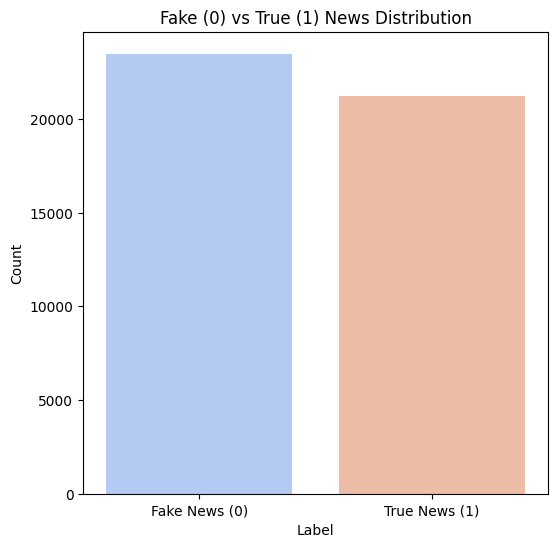

In [12]:
plt.figure(figsize=(6,6))
sns.countplot(data=data,x='label', palette='coolwarm')
plt.title('Fake (0) vs True (1) News Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Fake News (0)', 'True News (1)'], rotation=0)
plt.show()

#### 2. Word count distribution per class

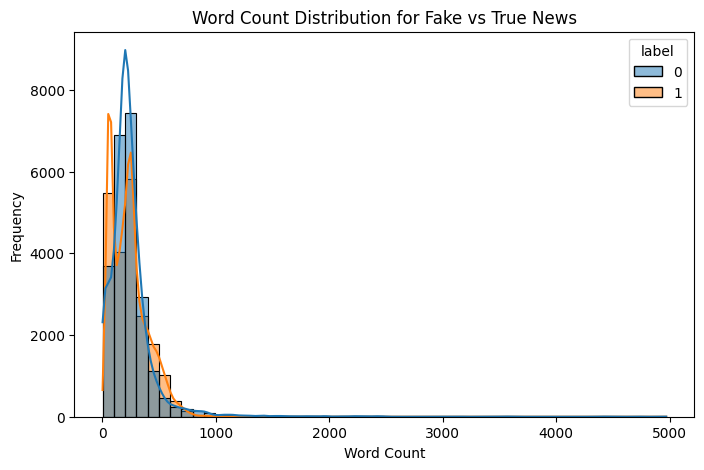

In [13]:
plt.figure(figsize=(8,5))
# data['word_count'] = data['clean_content'].apply(lambda x: len(x.split()))
sns.histplot(data=data, x='token_count', hue='label', bins=50, kde=True)
plt.title('Word Count Distribution for Fake vs True News')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

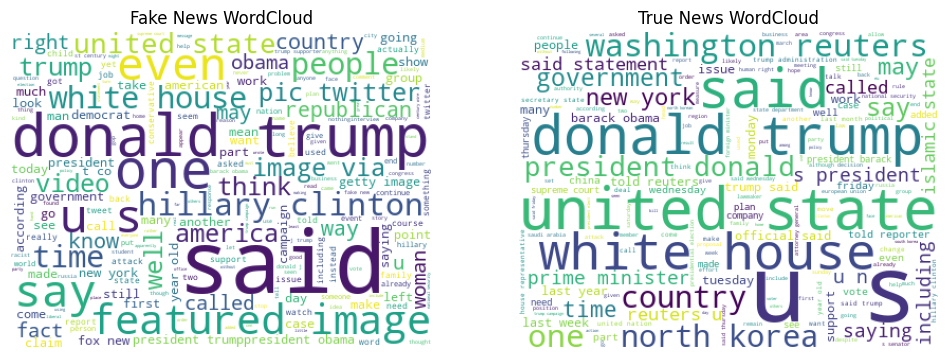

In [14]:
from wordcloud import WordCloud

fake_text = ' '.join(data[data['label']==0]['clean_content'])
true_text = ' '.join(data[data['label']==1]['clean_content'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(fake_text))
plt.title('Fake News WordCloud')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=400, height=300, background_color='white').generate(true_text))
plt.title('True News WordCloud')
plt.axis('off')
plt.show()

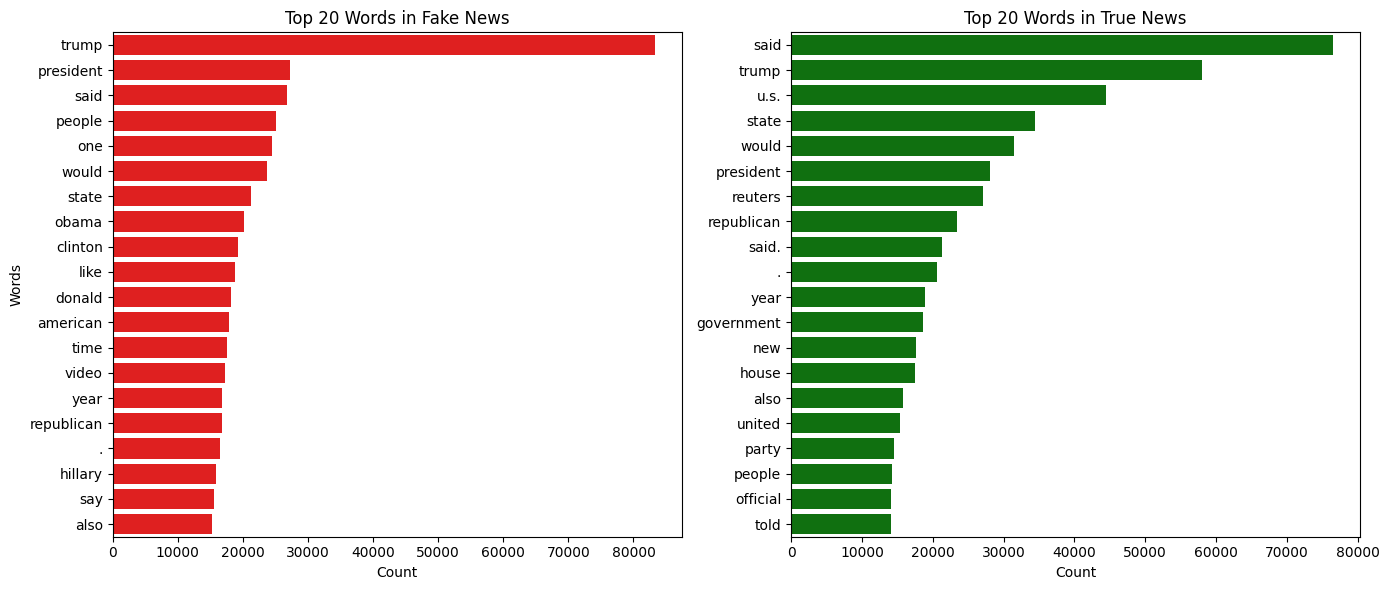

In [16]:
from collections import Counter

# Function to get top N words
def get_top_words(texts, n=20):
    words = " ".join(texts).split()
    freq = Counter(words)
    return pd.DataFrame(freq.most_common(n), columns=['Word', 'Count'])

# Get top words for Fake and True news
top_fake = get_top_words(data[data['label'] == 0]['clean_content'])
top_true = get_top_words(data[data['label'] == 1]['clean_content'])

# Create subplots
plt.figure(figsize=(14, 6))

#  Subplot 1: Fake News
plt.subplot(1, 2, 1)
sns.barplot(x='Count', y='Word', data=top_fake, color='red')
plt.title("Top 20 Words in Fake News")
plt.xlabel("Count")
plt.ylabel("Words")

#  Subplot 2: True News
plt.subplot(1, 2, 2)
sns.barplot(x='Count', y='Word', data=top_true, color='green')
plt.title("Top 20 Words in True News")
plt.xlabel("Count")
plt.ylabel("")

plt.tight_layout()
plt.show()

### 5. Feature Extracting

In [17]:
data.columns

Index(['title', 'text', 'subject', 'date', 'label', 'content', 'clean_content',
       'token_count'],
      dtype='object')

In [18]:
x = data['clean_content']
y = data['label']

In [19]:
x.head()

0    trump blame charlotte rioting drug use without...
1    man island china warns straying party path bei...
2    cnn panel melania cyberbullying stance talk hu...
3    trump say immigration deal democrat close with...
4    episode drive wire new management patrick shaw...
Name: clean_content, dtype: object

In [20]:
y.head()

0    0
1    1
2    0
3    1
4    0
Name: label, dtype: int64

#### split data into training and testing

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 40) # train_size = 0.8

In [22]:
x_train.head()

35194    trump ask former fbi director comey pledge loy...
44553    obamas gave heartbreaking tribute muhammad ali...
14117    ups secretly fly refugee u.s. middle east watc...
8554     fired billboard going bring house speaker paul...
24074    actress emmy rossum fire back trump fan disgus...
Name: clean_content, dtype: object

In [23]:
x_test.head()

25394    updated video america conservative family expe...
24955    eu withdrawal bill vital ensuring orderly brex...
40105    reince priebus say going forward trump complet...
2291     whoa melania trump break silence fire back tru...
19002    florida voter kick racist corrupt state prosec...
Name: clean_content, dtype: object

### Using TF - IDF Vectorization

#### fit_transform() : learning + transformation

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [25]:
x_train_transform = vectorizer.fit_transform(x_train)

In [26]:
x_train_transform.shape

(35751, 102331)

#### transform()

In [27]:
x_test_transform = vectorizer.transform(x_test)

In [28]:
x_test_transform.shape

(8938, 102331)

#### Vectorize only clean content

In [29]:
pd.DataFrame(
    x_train_transform[:5, :10].toarray(),
    columns = vectorizer.get_feature_names_out()[:10]
)

,aa,aaa,aaaaaaaand,aaaaapkfhk,aaaahhhh,aaaand,aaarf,aab,aaba,aabfsv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
pd.DataFrame(
    x_test_transform[:5, :10].toarray(),
    columns = vectorizer.get_feature_names_out()[:10]
)

,aa,aaa,aaaaaaaand,aaaaapkfhk,aaaahhhh,aaaand,aaarf,aab,aaba,aabfsv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Model Building

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [32]:
# Train Naive Bayes model
naive_bayes = MultinomialNB()
naive_bayes.fit(x_train_transform, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


#### Model Evaluation

In [33]:
y_pred = naive_bayes.predict(x_test_transform)

In [34]:
print(y_test,y_pred)
print(classification_report(y_test, y_pred))
print(y_test, y_pred)

25394    0
24955    1
40105    0
2291     0
19002    0
        ..
20684    0
1073     0
34249    0
21209    1
7776     0
Name: label, Length: 8938, dtype: int64 [0 1 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      4708
           1       0.95      0.92      0.94      4230

    accuracy                           0.94      8938
   macro avg       0.94      0.94      0.94      8938
weighted avg       0.94      0.94      0.94      8938

25394    0
24955    1
40105    0
2291     0
19002    0
        ..
20684    0
1073     0
34249    0
21209    1
7776     0
Name: label, Length: 8938, dtype: int64 [0 1 0 ... 0 1 0]


<Figure size 600x400 with 0 Axes>

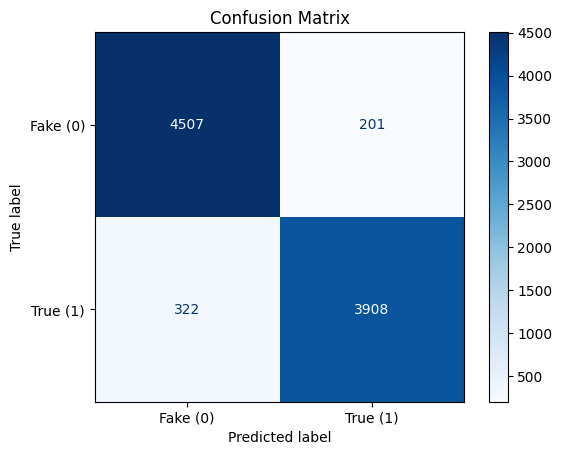

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualization
plt.figure(figsize=(6,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (0)', 'True (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

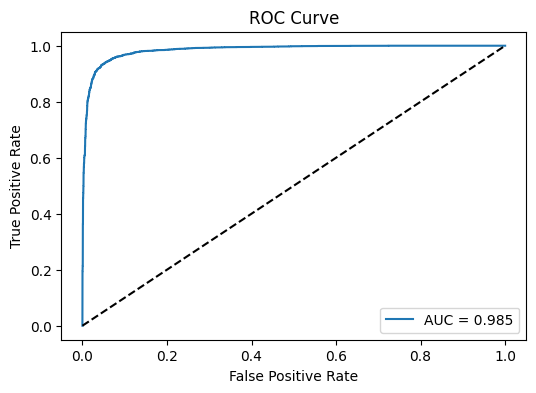

In [36]:
from sklearn.metrics import roc_curve, auc

# Use your trained model name (example: model)
# And your transformed test data (example: X_test_tfidf)

y_proba = naive_bayes.predict_proba(x_test_transform)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


### Error Analysis

In [37]:
errors = x_test[(y_pred != y_test)]
print("Total Misclassified Samples:", errors.shape[0])

Total Misclassified Samples: 523


In [38]:
errors = x_test.copy()
errors = errors.reset_index(drop=True)

error_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),
    'Predicted': y_pred,
    'Text': errors
})

misclassified = error_df[error_df['Actual'] != error_df['Predicted']]
misclassified.head(10)

,Actual,Predicted,Text
25,1,0,medical student faculty rally try save obamaca...
61,1,0,trump sexual assault accuser want stop movemen...
65,0,1,repeat deceit u try link iran al qaeda come in...
81,0,1,congress warned threat nuclear emp attack neve...
83,1,0,aardvark dy blaze london zoo meerkat missing l...
95,1,0,clinton sander agree april debate cnn reuters ...
98,0,1,climate change refugee fed give billion grant ...
105,1,0,trump cruz tension may provide liveliest repub...
121,1,0,immigrant across u.s. skip work school anti tr...
151,1,0,clinton book say trump debate stalking made sk...


### Insights

In [39]:
print("The model separates fake and real news based on word patterns learned from the text.")
print("It confidently predicts clear, well-structured articles as real and detects sensational or misleading language as fake.")
print("It may misclassify when fake news looks professional or when real news uses emotional wording.")
print("Overall, it is fast, accurate, and effective for text-based fake-news detection.")

The model separates fake and real news based on word patterns learned from the text.
It confidently predicts clear, well-structured articles as real and detects sensational or misleading language as fake.
It may misclassify when fake news looks professional or when real news uses emotional wording.
Overall, it is fast, accurate, and effective for text-based fake-news detection.
